# NDVI Activity

In [1]:
from pathlib import Path

import xarray as xr
import numpy as np

In [2]:
def preprocess_function(ds):
    """
    This function assigns a new value to the `band` coordinate that corresponds
    to the band number of in the filename.
    """
    # Extract band number
    filepath = Path(ds.encoding['source'])
    band_str = filepath.stem.split('_')[-1]
    # Assign as the coordainte
    ds = ds.assign_coords(xr.Coordinates({"band": [int(band_str[1])]}))
    return ds

In [3]:
landsat = xr.open_mfdataset(
    'data/LC09_L2SP_015034_20250414_20250415_02_T1/LC09_L2SP_015034_20250414_20250415_02_T1_SR_B*.TIF',
    concat_dim='band', combine='nested', preprocess=preprocess_function,
)

In [4]:
landsat

<xarray.Dataset> Size: 2GB
Dimensions:      (band: 7, y: 7951, x: 7841)
Coordinates:
  * x            (x) float64 63kB 1.737e+05 1.737e+05 ... 4.089e+05 4.089e+05
  * y            (y) float64 64kB 4.269e+06 4.269e+06 ... 4.031e+06 4.03e+06
    spatial_ref  int64 8B 0
  * band         (band) int64 56B 1 2 3 4 5 6 7
Data variables:
    band_data    (band, y, x) float32 2GB dask.array<chunksize=(1, 256, 256), meta=np.ndarray>

### Question 1

This dataset shows surface reflectance data. Surface reflectance _should_ range from 0 to 1, indicating what fraction of the incoming radition was reflected back to the atmosphere.

**Problem**

Print the min and max values of the red band (band 4) of the dataset. Use the `band_data` variable. Are the raw values between 0 and 1?



:::{admonition} Hint
:class: note, dropdown
Because this Dataset was created from a multi-file dataset the data by default is not automatically read from the file. To prompt the data to load add the `.load()` method to the **end** of your data analysis.
:::

In [5]:
print('raw minimum value:', landsat.band_data.sel(band=4).min().load().values)
print('raw maximum value:', landsat.band_data.sel(band=4).max().load().values)

raw minimum value: 1486.0
raw maximum value: 49542.0


### Question 2

We learned in the first lesson about floats and integers. While both are numbers, integers take up MUCH less space to store when writing a data file.

Becuase of this, it is common that data will use a **scale** and **offset** value to adjust the data values and store them as integers instead of floats. Whenever someone opens the dataset to use the data they first need to use an equation to apply the scale and offset to the data to get the correct data values.

**Problem** To calculate the correct surface reflectance values, apply the following formula to the data:

> corrected_data = raw_data * 0.0000275 - 0.2

The `landsat` Dataset above is the _raw_data_ in the equation above. Check to see if the minimum and maximum values are closer to 0-1.

In [6]:
landsat = (landsat * 0.0000275) - 0.2

In [7]:
print('corrected minimum value:', landsat.band_data.sel(band=4).min().load().values)
print('corrected maximum value:', landsat.band_data.sel(band=4).max().load().values)

corrected minimum value: -0.159135
corrected maximum value: 1.162405


### Question 3

NDVI is calculated using data from the red band (band 4) and the near infrared band (band 5). 

**Problem**

Create two new data variables containing DataArrays for each the red and near infrared (nir) bands. (Each DataArray should have two dimensions). Load all the data into the band.

In [8]:
red = landsat.band_data.sel(band=4).load()
nir = landsat.band_data.sel(band=5).load()

In [9]:
red

<xarray.DataArray 'band_data' (y: 7951, x: 7841)> Size: 249MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x            (x) float64 63kB 1.737e+05 1.737e+05 ... 4.089e+05 4.089e+05
  * y            (y) float64 64kB 4.269e+06 4.269e+06 ... 4.031e+06 4.03e+06
    spatial_ref  int64 8B 0
    band         int64 8B 4

### Problem 4

**Problem**

Make a plot of the red band. _(This will take several seconds to load)_

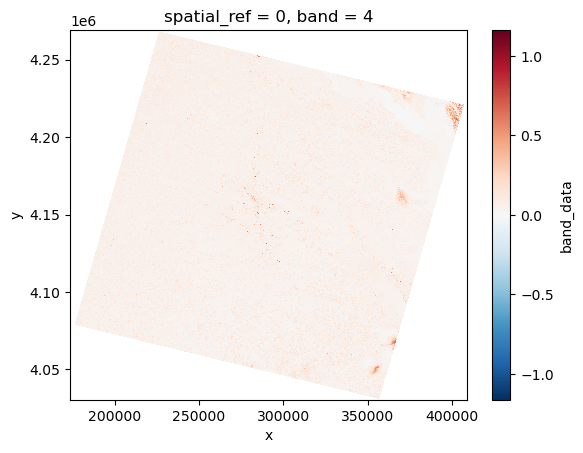

In [11]:
red.plot()

### Question 5

Recall that surface reflectance values _should_ be between 0 and 1. Sometimes, though we get some values outside of that range (as seen in our dataset). 

**Problem**

Mask out any surface reflectance values in the datasets that are outside the range of 0 to 1.

In [10]:
red = red.where((red > 0) & (red < 1))
nir = nir.where((nir > 0) & (nir < 1))

### Question 6

NDVI is the Normalized Difference Vegetation Index. It provides a measure for how much "greeness" is in an area, giving a quantification of green vegetation. The function for calculating NDVI is:

$ NDVI = \frac{NIR - Red}{NIR + Red}$

The values of NDVI range from 1 (very green) to -1 (no vegetation at all).

**Problem**

Use the formula above to create a new `ndvi` DataArray. Assign it to a new variable.

In [11]:
ndvi = (nir - red) / (nir + red)

In [12]:
ndvi

<xarray.DataArray 'band_data' (y: 7951, x: 7841)> Size: 249MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x            (x) float64 63kB 1.737e+05 1.737e+05 ... 4.089e+05 4.089e+05
  * y            (y) float64 64kB 4.269e+06 4.269e+06 ... 4.031e+06 4.03e+06
    spatial_ref  int64 8B 0

Congratulations! You just calculated NDVI!

### Bonus Question A

**Problem**

Check that the minimum and maximum ndvi values are between -1 and 1.

In [15]:
ndvi.max()

<xarray.DataArray 'band_data' ()> Size: 4B
array(0.999817, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0

In [16]:
ndvi.min()

<xarray.DataArray 'band_data' ()> Size: 4B
array(-0.99967253, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0

### Bonus Question B

**Problem**

Make a plot of the NDVI DataArray.

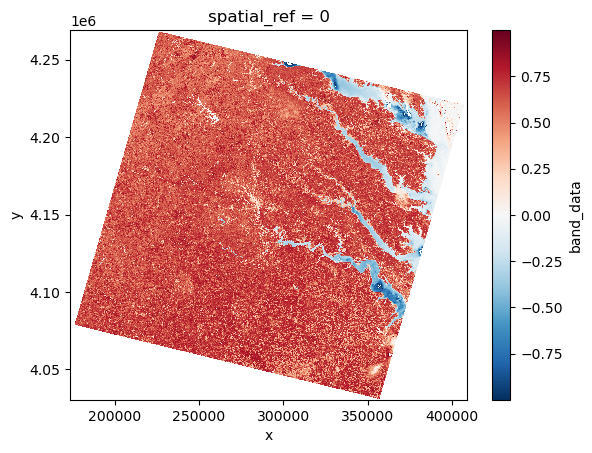

In [17]:
ndvi.plot()

### Bonus Question C

Negative values are usually water, ice, and snow. Since those are rare in our scene and we want to focus on vegetation we can de-emphasize those in our image using the `vmin` argument. This helps us focus on the variability that is more common in our image.

**Problem**

The `vmin` argument changes the lowest value on the color bar so that values below a certain threshold aren't distiguishable from other values. Use the `vmin` argument in the `.plot()` function and set `vmin` to 0.

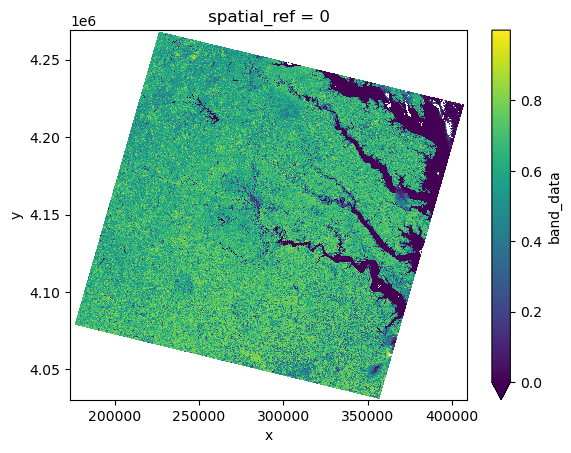

In [14]:
ndvi.plot(vmin=0)

## Code Summary

In [ ]:
# Apply the scale and offset factors
landsat = (landsat * 0.0000275) - 0.2

# Extract the red and near infrared bands
red = landsat.band_data.sel(band=4).load()
nir = landsat.band_data.sel(band=5).load()

# Mask out invalid values
red = red.where((red > 0) & (red < 1))
nir = nir.where((nir > 0) & (nir < 1))

# Calculate NDVI
ndvi = (nir - red) / (nir + red)

# Plot NDVI with values less than 0 smoothed out
# ndvi.plot(vmin=0)

### Save the dataset

See also: `.to_netcdf()` (also works for HDF files)

In [16]:
ndvi.rio.to_raster('data/ndvi.tif')